# Introduction au modèle MAOOAM

Ce notebook est une introduction au modèle couplé ocean-atmosphère MAOOAM. Pour plus d'information sur le modèle lui-même, vous pouvez consulter l'article:

* De Cruz, L., Demaeyer, J. and Vannitsem, S. (2016). *The Modular Arbitrary-Order Ocean-Atmosphere Model: MAOOAM v1.0*, Geosci. Model Dev., **9**, 2793-2808. doi:[10.5194/gmd-9-2793-2016](https://doi.org/10.5194/gmd-9-2793-2016).

Le modèle est implémenter ici via le code `qgs`. La documentation complète de ce code est disponible sur le site

> [qgs.readthedocs.io](https://qgs.readthedocs.io/en/latest/)

## Installation de qgs avec pip

La manière la plus simple d'installer `qgs` est via [pip](https://pypi.org/). Il suffit de décommenté la ligne suivante et de la lancée:

In [ ]:
#!pip install qgs

et vous êtes prêt !

## Faire tourner le modèle

En utilisant `qgs`, on va maintenant définir un modèle atmosphérique quasigéostrophique à 2 couches couplé à modèle d'océan quasi-géostrophique à couche mince. Le couplage est à la fois via la friction méchanique et par échange de chaleur.

**Pour commencer, exécutez simplement le notebook actuel et suivez les cellules jusqu'en bas.**

### Import des modules nécéssaires

Modules graphiques et numériques:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Modules du modèle:

In [ ]:
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator, RungeKuttaTglsIntegrator
from qgs.functions.tendencies import create_tendencies

et les diagnostiques de celui-ci:

In [ ]:
from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic, OceanicLayerStreamfunctionDiagnostic
from qgs.diagnostics.temperatures import MiddleAtmosphericTemperatureDiagnostic, OceanicLayerTemperatureDiagnostic
from qgs.diagnostics.variables import VariablesDiagnostic, GeopotentialHeightDifferenceDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic

### Definition du modèle

Tout d’abord, nous définissons quelques paramètres généraux qui seront important plus loin

In [ ]:
# Increment temporel de l'intégration numérique
dt = 0.1
# Nous sauverons l'état du modèle tous les 100 pas
write_steps = 100
# Nombre de boucles pour le transient
n_transient_time = 10
# Temps total de chaque intégration du modèle
integration_time = 1000000.

Nous allons maintenant créer l'objet paramètres du modèle. Il s'agit d'un objet qui définit entièrement la version et les paramètres du modèle. Cet objet sera utilisé par qgs pour construire les tendances $\boldsymbol{f}$ du modèle.

In [ ]:
model_parameters = QgParams()

Nous indiquons que nous voulons un canal atmosphérique pour l'atmosphère, avec des modes de Fourier jusqu'au nombre d'onde 2 dans chaque direction spatiale (directions $x$ et $y$, qui seront clarifiées ci-dessous). Pour l'océan, on veut un bassin fermé avec des modes de Fourier allant jusqu'au nombre d'onde 2 pour la direction $x$, mais 4 pour la direction $y$.

In [ ]:
# Troncature de mode au nombre d'onde 2 dans les coordonnées spatiales x et y
# pour l'atmosphère
model_parameters.set_atmospheric_channel_fourier_modes(2, 2)
# Troncature de mode au nombre d'onde 2 dans les coordonnées spatiales x et au
# nombre d'onde 4 dans les coordonnées spatiales y pour l'océan
model_parameters.set_oceanic_basin_fourier_modes(2, 4)

Nous pouvons maintenant configurer certains paramètres avec la méthode [`set_params`](https://qgs.readthedocs.io/en/latest/files/technical/configuration.html#qgs.params.params.Params.set_params) de l'objet paramètres :

In [ ]:
# Réglage des paramètres MAOOAM selon la publication indiquée ci-dessus
model_parameters.set_params({'kd': 0.0290, 'kdp': 0.0290, 'n': 1.5, 'r': 1.e-7,
                             'h': 136.5, 'd': 1.1e-7})
model_parameters.atemperature_params.set_params({'eps': 0.7, 'T0': 289.3,
                                                 'hlambda': 15.06})
model_parameters.gotemperature_params.set_params({'gamma': 5.6e8, 'T0': 301.46})


Le paramètre de friction $d$ entre l'océan et l'atmosphère indiqué sur la première ligne est un paramètre important du modèle qui sera varié par la suite.

Nous définissons ensuite la composante de rayonnement à ondes courtes comme dans la publication ci-dessus : $C_{{\rm a},1}$ et $C_{{\rm o},1}$

In [ ]:
model_parameters.atemperature_params.set_insolation(103.3333, 0)
model_parameters.gotemperature_params.set_insolation(310, 0)


En particulier on varie $C_{{\rm o} , 1}$ en fixant $C_{{\rm a} , 1} = C_{{\rm o} , 1} / 3$, ce qui est réaliste et permet de réduire le nombre de paramètres à explorer.

Nous avons terminé la configuration du modèle. Nous pouvons maintenant imprimer les paramètres pour vérifier ce que nous avons fait :

In [ ]:
model_parameters.print_params()

Nous sommes maintenant prêts à alimenter l'objet paramètres de `qgs` pour obtenir les tendances $\boldsymbol{f}$ qui nous permettront d'intégrer l'équation différentielle $\dot{\boldsymbol{x}} = \boldsymbol{f}(\boldsymbol{x})$

In [ ]:
%%time
f, Df = create_tendencies(model_parameters)

### Integration temporelle

Nous pouvons maintenant intégrer notre modèle avec un intégrateur, un algorithme qui nous donnera la solution de l'équation différentielle ci-dessus. Il existe de nombreuses options pour le faire, mais ici nous utiliserons l'intégrateur intégré de `qgs` (un [intégrateur Runge-Kutta du 4ème ordre](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)) :

In [ ]:
integrator = RungeKuttaIntegrator()

Nous disons à cet intégrateur d’utiliser notre modèle défini ci-dessus:

In [ ]:
integrator.set_func(f)

Nous pouvons maintenant partir d'une condition initiale aléatoire et intégrer sur un temps long transitoire pour obtenir une condition initiale sur l'attracteur du modèle (ceci devrait prendre une dizaine de minutes):

In [ ]:
%%time
ic = np.random.rand(model_parameters.ndim)*0.001
# nous faisons une boucle de plusieurs intégrations
for i in range(n_transient_time):
    integrator.integrate(0., integration_time, dt, ic=ic, write_steps=0)  # write_steps=0 nous donnes seulement la dernière étape en sortie
    # on récolte le résultat qui est dans l'intégrateur
    time, ic = integrator.get_trajectories()

Maintenant que nous avons obtenu une condition initiale sur l'attracteur (stockée dans la variable `ic`), nous pouvons intégrer davantage pour obtenir une **trajectoire** sur l'attracteur

In [ ]:
%%time
integrator.integrate(0., integration_time, dt, ic=ic, write_steps=write_steps)
# on récolte le résultat qui est dans l'intégrateur
time, trajectory = integrator.get_trajectories()

Le modèle a fini de tourner et nous pouvons maintenant passé à l'analyse de la sortie du modèle, qui se trouve dans la variable `trajectory` (les temps de chaque état du modèle se trouve dans la variable correspondante `time`).

### Plot de la trajectoire du modèle

L'évolution temporelle typique d'une variable de modèle en fonction du temps peut maintenant être tracée. Par exemple, ici la variable $\psi_{{\rm a}, 1}$ qui représente l'évolution du pattern $F_1$ (voir ci-dessous).

In [ ]:
var = 0
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*time, trajectory[var])

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

Nous pouvons également tracer par exemple deux variables dans un plan. Ici les variables $\psi_{{\rm o}, 2}$ et $\delta T_{{\rm o}, 2}$:

In [ ]:
varx = 21
vary = 29
plt.figure(figsize=(10, 8))

plt.plot(trajectory[varx], trajectory[vary], marker='o', ms=0.07, ls='')

plt.xlabel('$'+model_parameters.latex_var_string[varx]+'$')
plt.ylabel('$'+model_parameters.latex_var_string[vary]+'$');

Ceci montre une projection bidimensionnelle de l'[attracteur](https://en.wikipedia.org/wiki/Attractor) du modèle, c'est-à-dire l'ensemble des états vers lesquels le modèle tend à évoluer, pour une grande variété de conditions de départ du système. On peut ici voir que ces 2 variables montrent une évolution proche de celle d'une orbite périodique.

Chaque point est un état du modèle. $\psi_{\rm{o},2}$ et $\delta T_{\rm{o},2}$ correspondent à la 22ème et 30ème variables du modèle. Ce sont des coefficients *spectraux* du modèle. En effet, `qgs` est un modèle spectral. Cela signifie que tous ses champs sont développés sur des modes spatiaux. Ici par exemple, il y a quatres champs, la fonction de courant barotrope à 500hPa $\psi_{\rm{a}}$, la fonction de courant barocline à 500hPa $\theta_{\rm{a}}$, la fonction de courant barotrope $\psi_{\rm{o}}$ dans l'océan et l'anomalie de température dans l'océan $\delta T_{\rm{o}}$. Ils sont développés sur 10 modes dans l'atmosphère (car nous avons décidé de développer jusqu'au nombre d'onde 2 dans chaque direction) et 8 modes dans l'océan (idem mais dans la direction $y$ nous allons jusqu'au nombre d'onde 4):

$$\psi_{\rm{a}} = \sum_{i=1}^{10} \, \psi_{\rm{a},i} \, F_i(x,y)\qquad\qquad \mathrm{(1)}$$
$$\theta_{\rm{a}} = \sum_{i=1}^{10} \, \theta_{\rm{a},i} \, F_i(x,y) \qquad\qquad\,\, \mathrm{(2)}$$
$$\psi_{\rm{o}} = \sum_{i=1}^{8} \, \psi_{\rm{o},i} \, \phi_i(x,y)\qquad\qquad \mathrm{(3)}$$
$$\delta T_{\rm{o}} = \sum_{i=1}^{8} \, \delta T_{\rm{o},i} \, \phi_i(x,y) \qquad\qquad\,\, \mathrm{(4)}$$

où

$$ F_1(x,y) = \sqrt{2}\, \cos(y), \\ F_2(x,y) = 2\, \cos(n x)\, \sin(y), \\ F_3(x,y) = 2\, \sin(n x)\, \sin(y), \\ F_4(x,y) = \sqrt{2}\, \cos(2y), \\ F_5(x,y) = 2 \cos(n x) \sin(2y), \\ F_6(x,y) = 2 \sin(n x) \sin(2y), \\ \vdots $$

et

$$ \phi_1(x,y) = 2\, \sin(\frac{n}{2} x)\, \sin(y), \\ \phi_2(x,y) = 2\, \sin(\frac{n}{2} x)\, \sin(2 y), \\ \phi_3(x,y) = 2\, \sin(\frac{n}{2} x)\, \sin(3 y), \\ \phi_4(x,y) =  2\, \sin(\frac{n}{2} x)\, \sin(4 y), \\ \phi_5(x,y) = 2\, \sin(n x)\, \sin(y), \\ \vdots $$


$x$ et $y$ sont les coordonnées adimensionnelles sur le domaine spatial du modèle (un plan $\beta$) : $x \in [0, 2\pi/n]$ et $y \in [0,\pi]$, avec $n$ le rapport d'aspect du domaine, c'est-à-dire le rapport entre l'étendue zonale et méridionale du domaine.

Voici les 10 modes (présentés pour $n=1$) sur lesquels les champs spatiaux $\psi_{\rm{a}}$ et $\theta_{\rm{a}}$ du modèle sont décomposés :
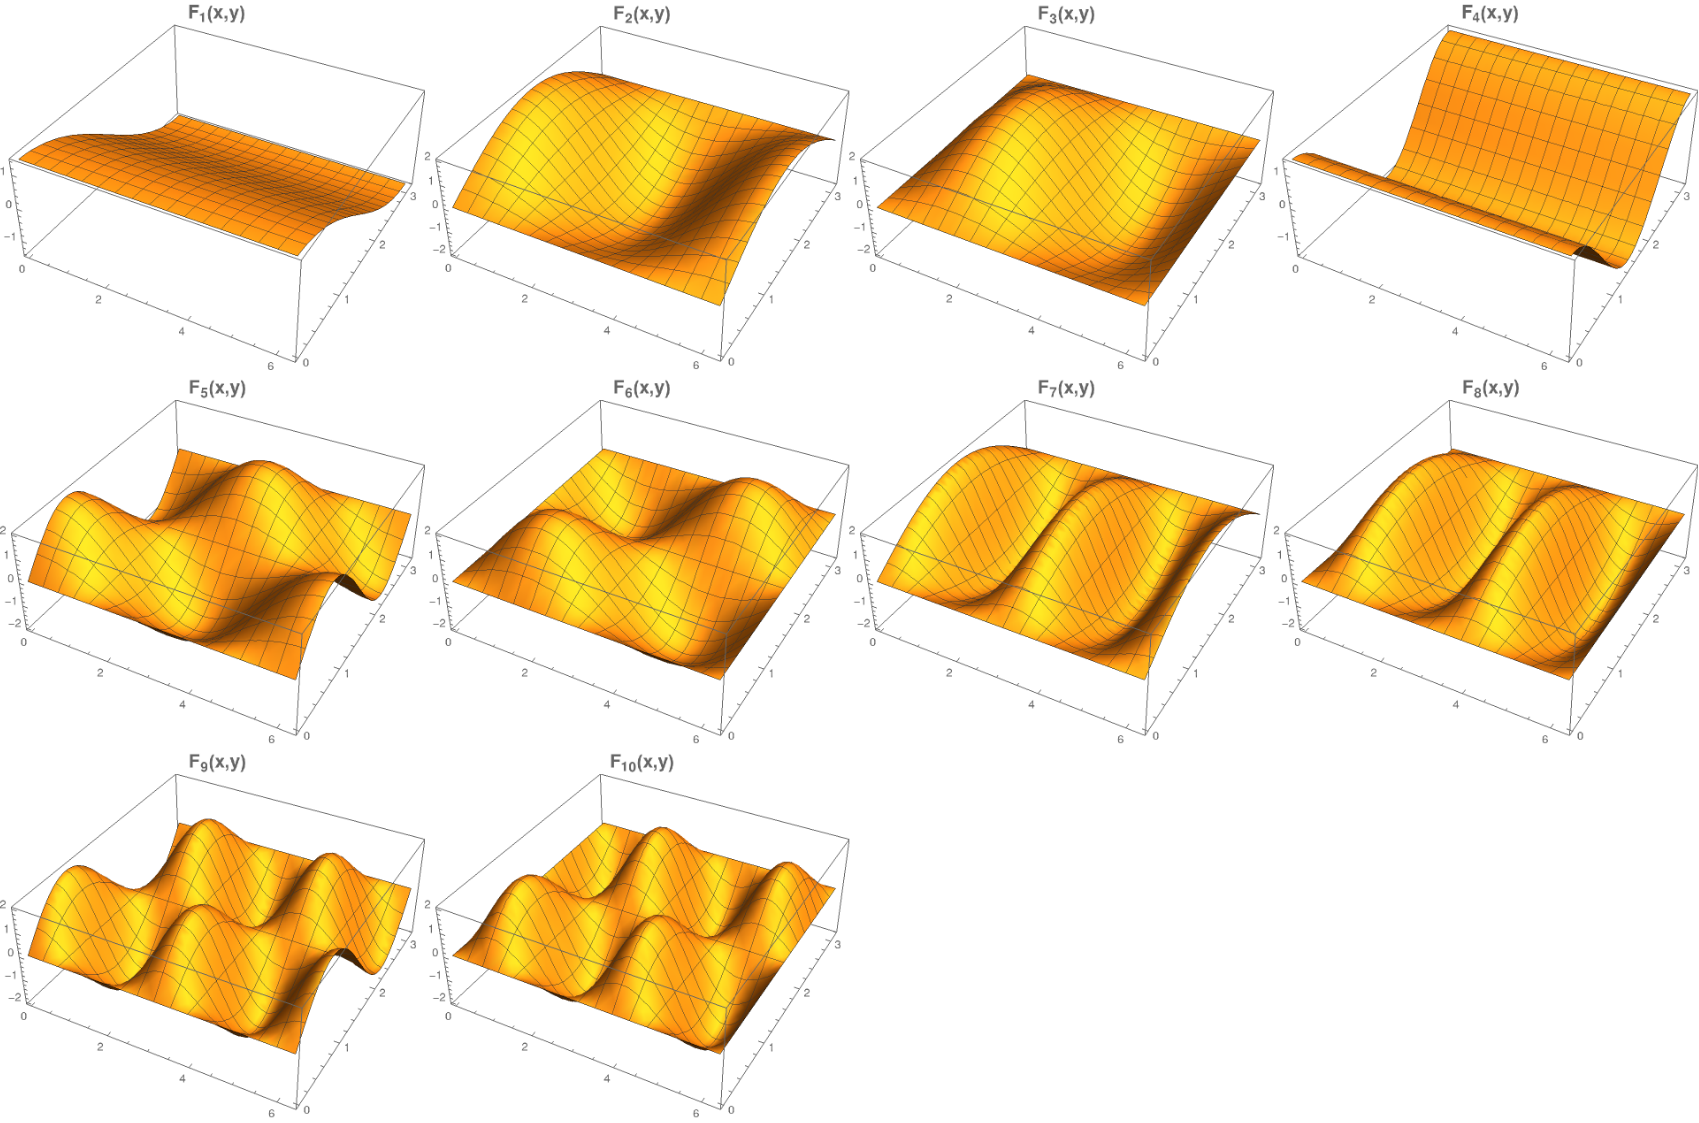

Et voici les 8 modes (présentés pour $n=1$) sur lesquels les champs spatiaux $\psi_{\rm{o}}$ et $\delta T_{\rm{o}}$ du modèle sont décomposés :
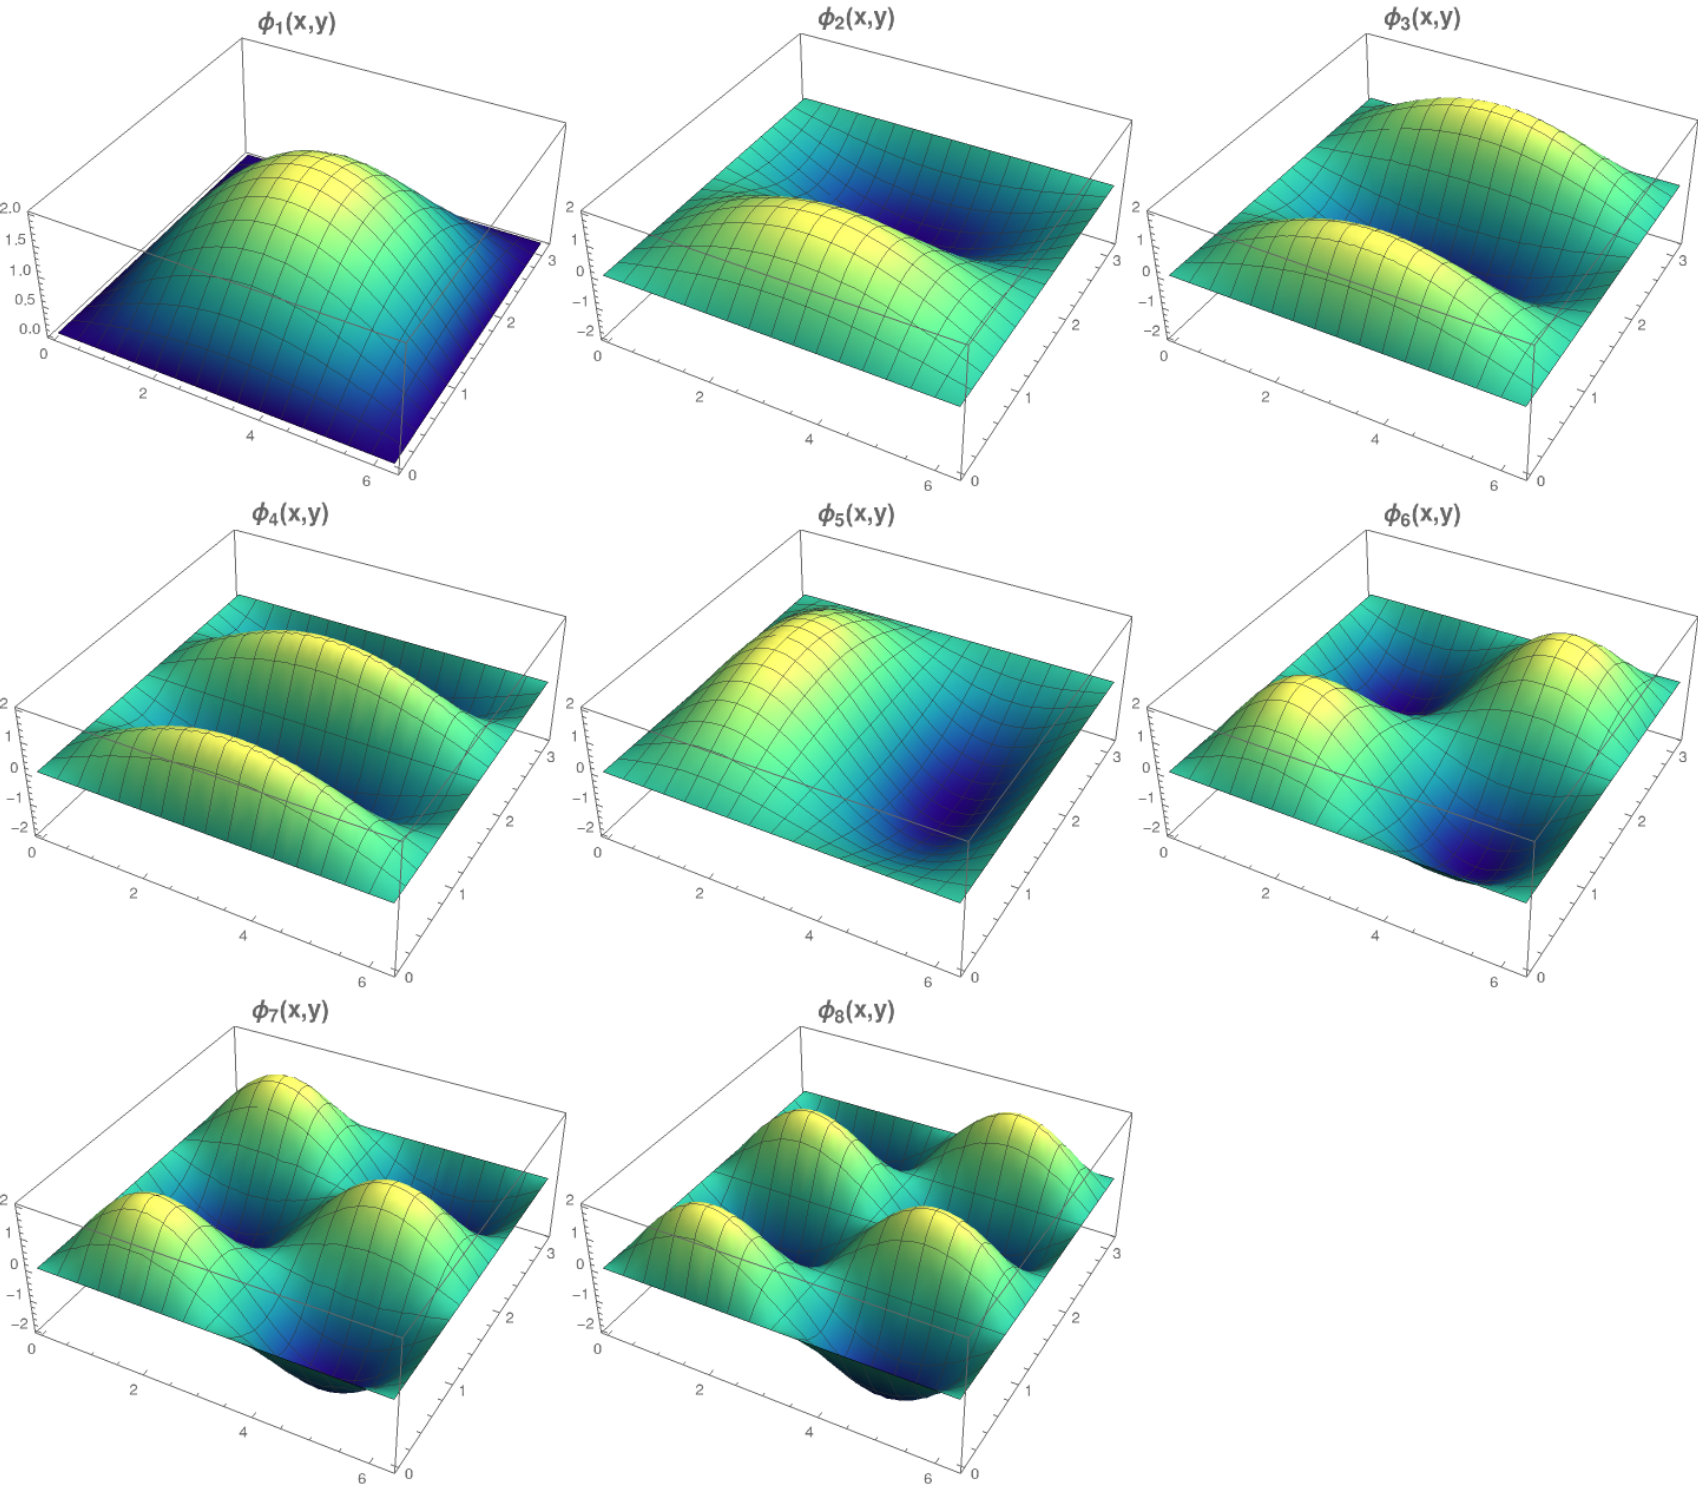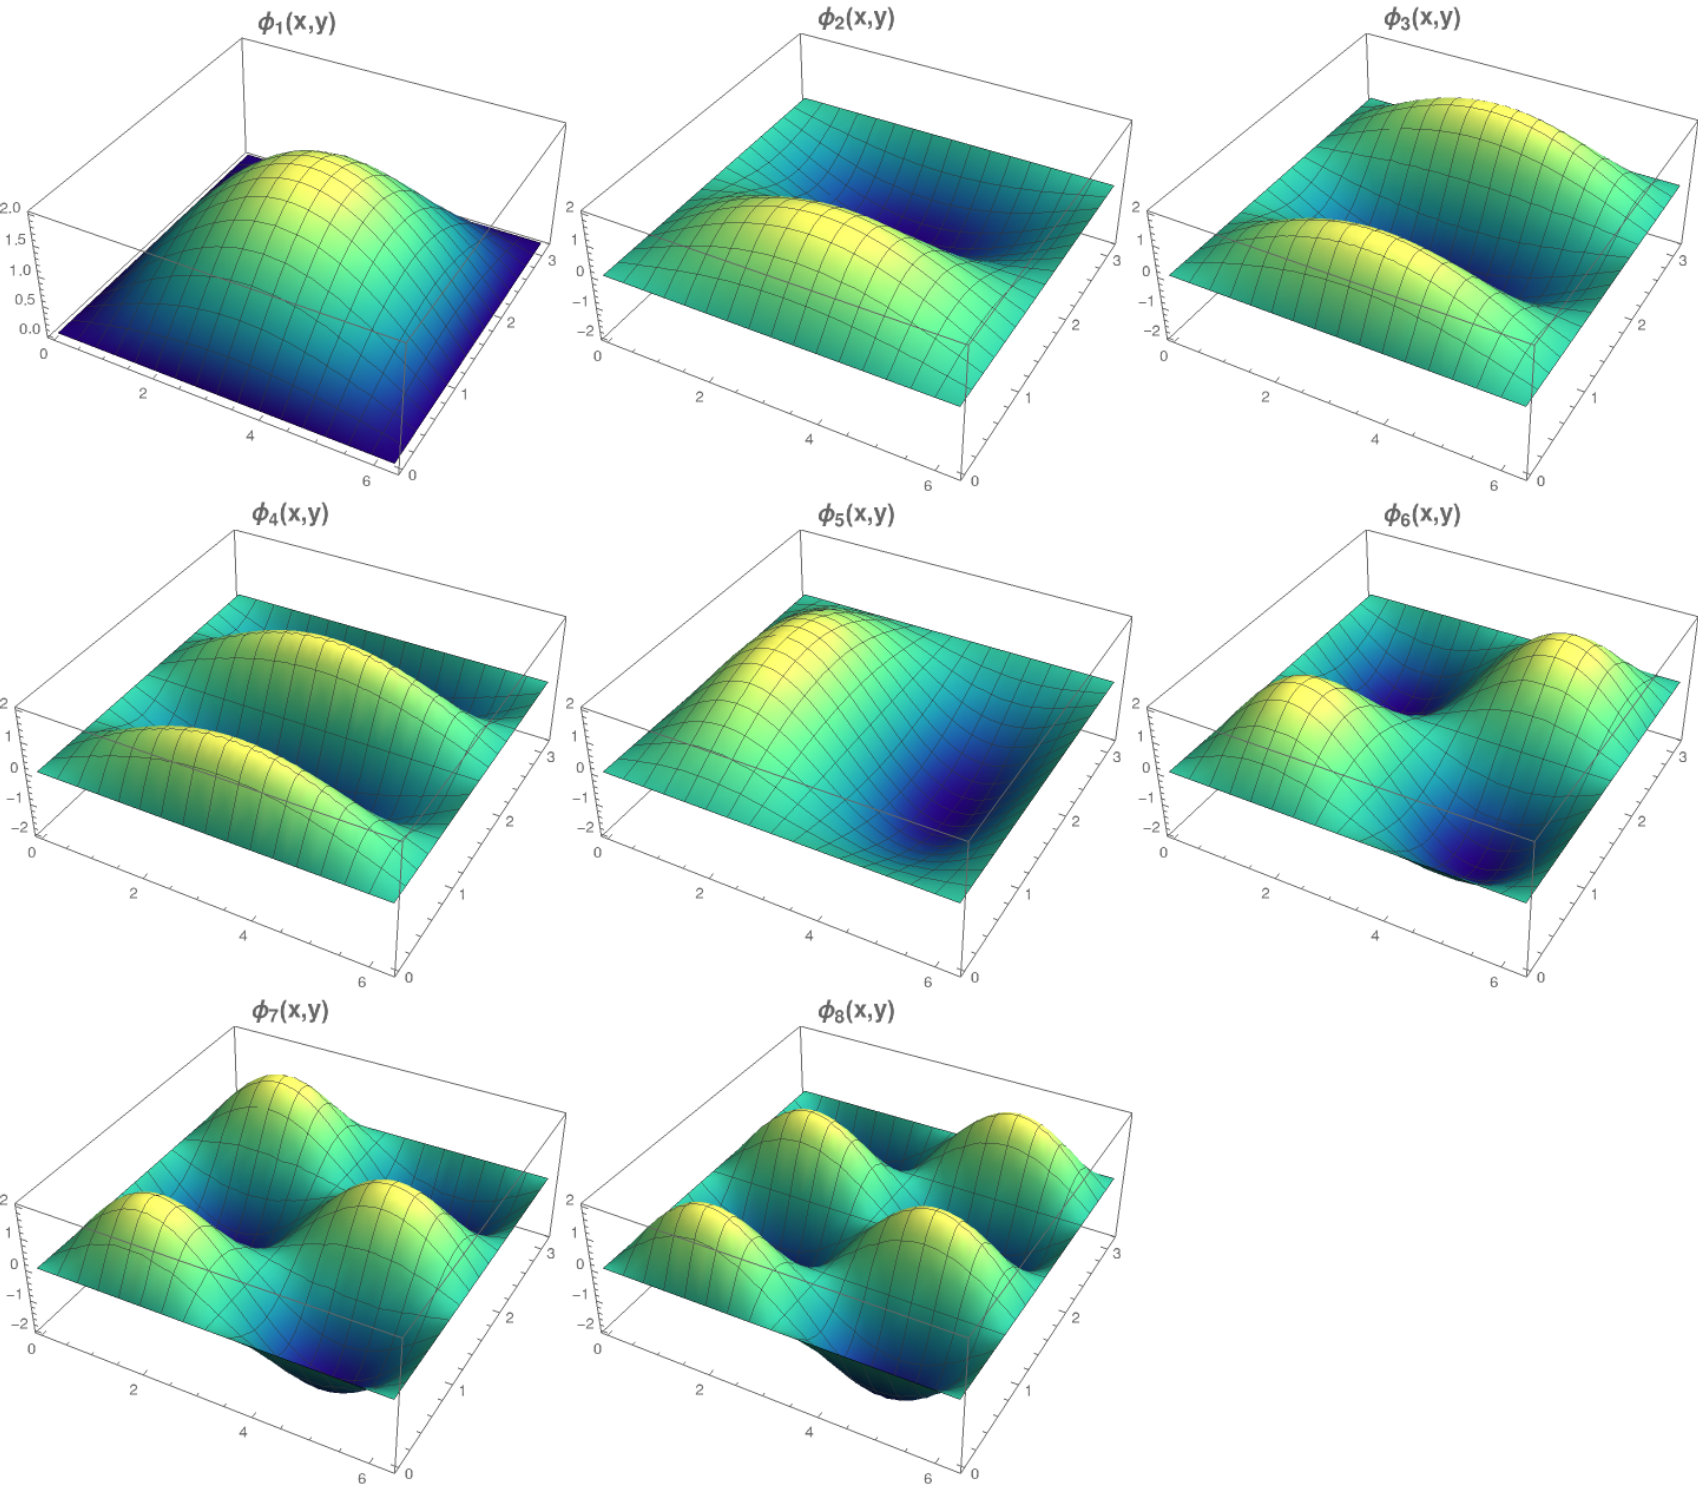

Maintenant, lorsque nous intégrons $\dot{\boldsymbol{x}} = \boldsymbol{f}(\boldsymbol{x})$, nous intégrons une équation différentielle pour l'évolution temporelle des coefficients spectraux $\psi_{\rm{a}, i}$, $\theta_{\rm{a}, i}$, $\psi_{\rm{o}, i}$ et $\delta T_{\rm{o}, i}$. C'est-à-dire que dans notre cas, $\boldsymbol{x} = (\psi_{\rm{a}, 1}, \ldots, \psi_{\rm{a}, 10}, \theta_{\rm{a}, 1}, \ldots, \theta_{\rm{a}, 10}, \psi_{\rm{o}, 1}, \ldots, \psi_{\rm{o}, 8}, \delta T_{\rm{o}, 1}, \ldots, \delta T_{\rm{o}, 8})$, et la résolution de l'équation différentielle du modèle nous permet de déterminer $\boldsymbol{x}(t)$. Avec les équations (1) à (4), il est alors facile de reconstruire l'évolution temporelle des champs spatiaux du modèle. C'est exactement ce que font les objets [`Diagnostic`](https://qgs.readthedocs.io/en/latest/files/technical/diagnostics.html) du modèle, et le sujet de la section suivante.

> **Info :** consultez cette [page](https://qgs.readthedocs.io/en/latest/files/model/oro_model.html) pour plus de détails sur l'expansion spectrale.

### Calcul et représentation des champs spatiaux du modèle

Le calcul et la représentation des champs du modèle peuvent être effectués avec des objets appelés diagnostics, qui prennent la sortie de l'intégration du modèle (c'est-à-dire les coefficients spectraux) et la convertissent en champs spatiaux. Une liste des diagnostics actuellement disponibles est incluse dans cette section du [Guide d'utilisation des diagnostics](https://qgs.readthedocs.io/en/latest/files/user_guide.html#analyzing-the-model-s-output-with-diagnostics).

Pour ce tutoriel, nous allons calculer par exemple le champ spatial de hauteur géopotentielle de 500 hPa. Cela peut être fait avec le [`MiddleAtmosphericStreamfunctionDiagnostic`](https://qgs.readthedocs.io/en/latest/files/technical/diagnostics.html#qgs.diagnostics.streamfunctions.MiddleAtmosphericStreamfunctionDiagnostic) qui calcule $\psi_{\rm a}(x, y)$.

Pour le calculer, nous commençons par instancier l'objet :

In [ ]:
psi = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters)

Notez également que nous devons transmettre l’objet `model_parameters` que nous avons défini ci-dessus.

Nous devons maintenant transmettre les données d'intégration du modèle avec la méthode [`set_data`](https://qgs.readthedocs.io/en/latest/files/technical/diagnostics.html#qgs.diagnostics.base.Diagnostic.set_data) :

In [ ]:
psi.set_data(time, trajectory)

Le diagnostic peut désormais calculer les champs à la volée en appelant

In [ ]:
psi.diagnostic

Tous les champs spatiaux correspondant à l'évolution temporelle des variables du modèle sont renvoyés sous forme de tableau sur des points spécifiques $x$ et $y$ :

In [ ]:
psi.diagnostic.shape

Il y a ici 100001 pas de temps enregistrés d'un champ représenté par une grille de 10 par 10. Nous pouvons tracer un seul champ aux 100ème pas de temps enregistrés avec :

In [ ]:
plt.imshow(psi.diagnostic[100])

ou utilisez la fonction de tracé de diagnostic intégrée :

In [ ]:
psi.plot(100)

En guise de remarque finale, veuillez noter que les coordonnées $x$ ou $y$ des points de la grille sont disponibles dans l'objet de diagnostic sous la forme :

In [ ]:
psi._X

et

In [ ]:
psi._Y

### Affichage des champs résultants sous forme d'animation

Avec les diagnostics, on peut également montrer l'évolution temporelle des champs du modèle. Ici, nous montrons simultanément un nuage de points des variables $\psi_{{\rm a}, 1}$ et $\psi_{{\rm o}, 2$, et $\delta T_{{\rm o}, 2$. Pour plus de détails sur les diagnostics et comment les utiliser pour produire ce type d'animation, veuillez lire cette section du [Guide de l'utilisateur](https://qgs.readthedocs.io/en/latest/files/user_guide.html#analyzing-the-model-s-output-with-diagnostics).

In [ ]:
theta_a = MiddleAtmosphericTemperatureDiagnostic(model_parameters)
psi_o = OceanicLayerStreamfunctionDiagnostic(model_parameters)
theta_o = OceanicLayerTemperatureDiagnostic(model_parameters)
variable_nondim = VariablesDiagnostic([21, 29, 0], model_parameters, False)
geopot_dim = GeopotentialHeightDifferenceDiagnostic([[[np.pi/model_parameters.scale_params.n, np.pi/4], [np.pi/model_parameters.scale_params.n, 3*np.pi/4]]],
                                                    model_parameters, True)
background = VariablesDiagnostic([21, 29, 0], model_parameters, False)
background.set_data(time, trajectory)


In [ ]:
m = MultiDiagnostic(3,2)
m.add_diagnostic(geopot_dim, diagnostic_kwargs={'style':'moving-timeserie'})
m.add_diagnostic(variable_nondim, diagnostic_kwargs={'show_time':False, 'background': background, 'style':'3Dscatter'}, plot_kwargs={'ms': 0.2})
m.add_diagnostic(theta_a, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(psi, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(theta_o, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(psi_o, diagnostic_kwargs={'show_time':False})

m.set_data(time[:10000], trajectory[:, :10000])

In [ ]:
m.animate(figsize=(15, 18))

## Analyse de spectre de puissance

Une étape importante maintenant pour le travail est de caractériser les spectres de puissance des différentes composantes. Pour cela, aidez-vous de la fonction [`scipy.signal.periodogram`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html).

In [ ]:
# Import de la fonction
from scipy.signal import periodogram

In [ ]:
# Définition de la fréquence de sampling en jours
fs = dt * write_steps * model_parameters.dimensional_time

In [ ]:
# Calcul
f_psi_a, Pxx_spec_psi_a = periodogram(trajectory[0], fs, scaling="density")
f_theta_a, Pxx_spec_theta_a = periodogram(trajectory[10], fs, scaling="density")
f_psi_o, Pxx_spec_psi_o = periodogram(trajectory[21], fs, scaling="density")
f_deltaT_o, Pxx_spec_deltaT_o = periodogram(trajectory[29], fs, scaling="density")

In [ ]:
# Dessin
plt.loglog(f_psi_a, np.sqrt(Pxx_spec_psi_a), label=r'$\psi_{{\rm a}, 1}$')
plt.loglog(f_theta_a, np.sqrt(Pxx_spec_theta_a), label=r'$\theta_{{\rm a}, 1}$')
plt.loglog(f_psi_o, np.sqrt(Pxx_spec_psi_o), label=r'$\psi_{{\rm o}, 2}$')
plt.loglog(f_deltaT_o, np.sqrt(Pxx_spec_deltaT_o), label=r'$\delta T_{{\rm o}, 2}$')

plt.ylim(1.e-8, 101);
plt.title('Spectre de puissance')
plt.xlabel('Fréquence [jours$^{-1}$]')

plt.legend();

## Spectre de Lyapunov

Dans la boîte à outils de `qgs`, il est également possible de calculer les exposants et les vecteurs de Lyapunov de ce modèle.

In [ ]:
# Import du module de calcul des Lyapunovs
from qgs.toolbox.lyapunov import LyapunovsEstimator

On calcule les vecteurs de Lyapunov "Backward"

In [ ]:
%%time

# Calcul

blvint = LyapunovsEstimator()

blvint.set_func(f, Df)
blvint.compute_lyapunovs(0., 1000000., 2000000., 0.1, 0.1, ic, write_steps=write_steps)
# On extrait les vecteurs et les exposants de l'intégrateur
btl, btraj, bexp, bvec = blvint.get_lyapunovs()


On peut alors plotter la moyenne des exposants locaux obtenus:

In [ ]:
# Figure

plt.figure(figsize=(15, 4))

mean_exp = np.mean(bexp, axis=-1)

x_pos = np.arange(1.,model_parameters.ndim+1,1)

plt.bar(x_pos, mean_exp)

plt.vlines(x_pos, -0.55, np.minimum(0.,mean_exp)-0.035, linestyles='dashdot', colors='tab:gray')

plt.xticks(x_pos, map(str,range(1, model_parameters.ndim+1,1)))
yt=[-0.5,-0.4,-0.3,-0.2,-0.1,0.,0.1]
plt.yticks(yt, map(str,yt))

plt.xlim(x_pos[0]-1., x_pos[-1]+1.)
plt.ylim(np.min(mean_exp)-0.1, np.max(mean_exp)+0.1)

plt.ylabel("Lyapunov exponent");
plt.xlabel("Index of the Lyapunov exponent");

In [ ]:
# Figure en logarithme

plt.figure(figsize=(15, 4))

mean_exp = np.mean(bexp, axis=-1)

x_pos = np.arange(1.,model_parameters.ndim+1,1)

plt.semilogy(x_pos, np.abs(mean_exp))


plt.xticks(x_pos, map(str,range(1, model_parameters.ndim+1,1)))
#yt=[-0.5,-0.4,-0.3,-0.2,-0.1,0.,0.1]
#plt.yticks(yt, map(str,yt))

#plt.ylim(-0.001,0.0012)
plt.ylabel("Log | Lyapunov exponent |");
plt.xlabel("Index of the Lyapunov exponent");

On peut aussi plotter la deviation standard de chaque composante de chaque vecteur, ce qui correspond à sa variabilité (ou à l'énergie dans cette composante).

In [ ]:
# Calcul de moyennes temporelles des vecteurs (le dernier axe est le temps)
mean_bvec = np.mean(bvec, axis=-1)
std_bvec = np.std(bvec, axis=-1)

In [ ]:
# Plot de l'énergie dans chaque composante de chaque vecteur de Lyapunov
plt.matshow(np.log(np.abs(std_bvec)))

plt.xlabel('Index du vecteur')
plt.ylabel('Composante')
plt.xticks(np.arange(0.,36., 5.), [1, 6, 11, 16, 21, 26, 31, 36])
plt.yticks([0., 10., 20., 28., 35.], [r'$\psi_{{\rm a}, 1}$', r'$\theta_{{\rm a}, 1}$', r'$\psi_{{\rm o}, 1}$', r'$\delta T_{{\rm o}, 1}$', r'$\delta T_{{\rm o}, 8}$']);
plt.title('Vecteurs de Lyapunov - Energie dans chaque composante');

Chaque vecteur sur ce plot correspond à une colonne et à l'exposant correspondant sur le graphe plus haut. On peut voir que les vecteurs instables et le début du plateau se projettent surtout sur l'atmosphère et la temperature, alors que la fin du plateau correspond plutôt à un couplage avec l'océan. Est-ce que cela vous semble cohérent?

Voilà, ce notebook est terminé, mais l'exploration commence et vous pouvez refaire l'expérience en changeant les deux paramètres importants $d$ et $C_{{\rm o} , 1}$ (pour rappel, on fixe ici $C_{{\rm a} , 1} = C_{{\rm o} , 1} / 3$). En particulier, à $C_{{\rm o} , 1}$ fixé, il serait intéressant de trouver la valeur de $d$ pour laquelle la variabilité basse-fréquence commence à se développer. Pour cela vous pouvez recommencer à partir d'une valeur de $d$ de $10^{-8}$ et augmenter celle-ci petit à petit.